# Testing Zero-Inflated Count Matrix Factorization in Darmanis data 

In [104]:
from pCMF.misc import utils, plot_utils, print_utils
from pCMF.misc.model_wrapper import ModelWrapper
from pCMF.models.pcmf import pcmf

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
from scipy.stats import gamma

import operator
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
brain_tags = pd.read_csv('../../data/Brain/brainTags.csv')

In [3]:
brain_tags.rename(columns={'Unnamed: 0': 'Gene name'}, inplace=True)

In [4]:
gene_names = brain_tags['Gene name']

In [5]:
brain_tags = brain_tags.drop('Gene name', axis=1)

In [6]:
np.count_nonzero(brain_tags['GSM1657871'] == 0)

17862

In [7]:
brain_tags_np = np.array(brain_tags)

In [8]:
info = pd.read_csv('../../data/Brain/SraRunTable.txt', sep='\t')

In [9]:
mapping = [list(info.Sample_Name_s).index(cell_name) if cell_name in list(info.Sample_Name_s) else None for cell_name in list(brain_tags.columns)]

In [10]:
cell_type = info.cell_type_s[mapping]

In [11]:
types, labels = np.unique(cell_type, return_inverse=True)

In [12]:
## Assign each cell a color according to its type
scols = ["red","blue","green","brown","pink","purple","darkgreen","grey"]
cols = []
for i in range(len(cell_type)):
    cols.append(scols[np.argwhere(list(cell_type)[i]==types)[0][0]])

In [13]:
cell_type[cell_type == types[0]] = "fetal quiescent"
cell_type[cell_type == types[1]] = "fetal replicating"
#cell_type[cell_type == types[-1]] = "oligodendrocyte precursor cells"

# Change to clearer cell type names
types[0] = "fetal quiescent"
types[1] = "fetal replicating"
#types[-1] = "oligodendrocyte precursor cells"

In [14]:
brain_10 = brain_tags[np.sum(brain_tags, axis=1) > 10]  # remove genes with zero expression across all cells

In [15]:
brain_10.shape

(18565, 420)

In [16]:
expression = np.array(brain_10).T

In [17]:
expression.shape

(420, 18565)

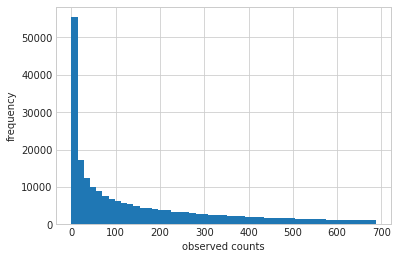

In [123]:
sortedex = np.sort(expression.flatten())[:int(0.9*expression.size)]

bins = np.linspace(0, sortedex.max(), num=50)

plt.hist(sortedex[sortedex>0], bins)
plt.xlabel('observed counts')
plt.ylabel('frequency')
plt.show()

In [61]:
stddevs = np.sort(np.std(expression, axis=0) / np.mean(expression, axis=0))

In [63]:
stddevs[stddevs > 10].shape

(4318,)

In [64]:
selected = np.std(expression, axis=0).argsort()[-1000:][::-1]

In [65]:
expression = expression[:, selected]

In [87]:
#train/test split
X_train, X_test, c_train, c_test, cell_type_train, _ = train_test_split(expression, labels, cell_type)

In [91]:
P = expression.shape[1]
K = 10 # latent space dimensionality
C = np.unique(c_train).size

In [105]:
# Run PCA
print('Running PCA...')
obj = PCA(n_components=K)
pca = ModelWrapper(np.log(X_train + 1.), c_train, name='PCA')
pca.run(obj.fit_transform)
print('Done.\n')

Running PCA...
Done.



In [135]:
T = 60. * 60.
S = 30.
max_iter = 1000000

In [136]:
print('Running PCMF models...')
cavi = pcmf.PCMF(X_train, c_train, X_test=X_test, sparsity=False)
cavi.run(max_iter=max_iter, max_time=T, sampling_rate=S, do_imp=False, do_holl=False, do_dll=False, verbose=True)
print('Done.\n')

Running PCMF models...
CAVI-EB:
Considering zero-inflated counts.
Running CAVI-EB...
Iteration 104/1000000. Log-likelihood: 1123.922. Elapsed: 1h0m1s8s
Done.



In [ ]:
print('Running PCMF models...')
cavi_noteb = pcmf.PCMF(X_train, c_train, X_test=X_test, sparsity=False, empirical_bayes=False)
cavi_noteb.run(max_iter=max_iter, max_time=T, sampling_rate=S, do_imp=False, do_holl=False, do_dll=False, verbose=True)
print('Done.\n')

Running PCMF models...
CAVI:
Considering zero-inflated counts.
Running CAVI...


In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
plot_utils.plot_model_convergence([cavi, cavi_noteb], mode='ll_time', ax=ax, ylabel='Average log-likelihood', xlabel='Seconds(*{0})'.format(S))
ax = plt.subplot(1, 2, 2)
plot_utils.plot_model_convergence([cavi, cavi_noteb], mode='silh_time', ax=ax, ylabel='Silhouette of latent space', xlabel='Seconds(*{0})'.format(S))
plt.legend(loc='upper left', bbox_to_anchor=[1., 1.], frameon=True)
plt.suptitle('Darmanis data', fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()

In [ ]:
print_utils.print_model_silhouettes([pca, cavi, cavi_noteb])

In [ ]:
fig = plt.figure(figsize=(14, 4))
ax = plt.axes()
plot_utils.plot_sorted_tsnes([pca, cavi, cavi_noteb], c_train, ax=ax, labels=np.array(cell_type_train), legend=True)
plt.show()